In [1]:
import collections
import math
import time

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pytz
import seaborn as sns
from fbprophet import Prophet
import tensorflow as tf

sns.set(font_scale=1.5, palette='colorblind')

/Users/srom/workspace/ds/env/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:923: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/Users/srom/workspace/ds/env/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Load data

### Electricity minutely file from a house in Vancouver (2012 - 2014) 

[AMPds](http://ampds.org/)

In [2]:
electricity_df = pd.read_csv('./data/AMPds/Electricity_P.csv')
electricity_df['date'] = pd.to_datetime(electricity_df['UNIX_TS'], unit='s')

In [3]:
print('Shape', electricity_df.shape)
print()
print("WHE means Whole House, and that's what we want to predict.")
electricity_df.head()

Shape (1051200, 25)

WHE means Whole House, and that's what we want to predict.


,UNIX_TS,WHE,RSE,GRE,MHE,B1E,BME,CWE,DWE,EQE,...,B2E,CDE,DNE,EBE,FGE,HTE,OUE,TVE,UNE,date
0,1333263600,918,43,2,873,0,352,0,0,41,...,58,0,30,0,0,4,0,37,138,2012-04-01 07:00:00
1,1333263660,913,43,0,870,0,354,0,0,35,...,58,0,30,0,0,4,0,37,138,2012-04-01 07:01:00
2,1333263720,872,43,2,827,0,354,0,0,41,...,8,0,30,0,0,4,0,37,138,2012-04-01 07:02:00
3,1333263780,872,43,2,827,0,354,0,0,40,...,7,0,30,0,0,4,0,37,142,2012-04-01 07:03:00
4,1333263840,772,41,2,729,0,352,0,0,40,...,8,0,31,0,0,4,0,37,45,2012-04-01 07:04:00


In [4]:
electricity_df.describe()[['WHE']]

,WHE
count,1.051200e+06
mean,1.112327e+03
std,9.462197e+02
min,0.000000e+00
25%,5.520000e+02
50%,7.580000e+02
75%,1.256000e+03
max,1.226000e+04


In [5]:
df = electricity_df[['date', 'WHE']].copy()
df['date'] = df['date'].apply(
    lambda v: pd.Timestamp(pytz.utc.localize(v.to_pydatetime()))
)
df = df.set_index('date')
df.columns = ['whe']

In [6]:
print('Event without data?')
df[df['whe'] == 0]

Event without data?


,whe
date,
2012-05-04 17:34:00+00:00,0
2013-06-17 17:06:00+00:00,0
2013-06-17 17:34:00+00:00,0
2013-06-17 17:36:00+00:00,0
2013-06-17 17:37:00+00:00,0
2013-06-17 17:38:00+00:00,0


In [7]:
# Drop outliers
df.drop(df.index[df['whe'] == 0], inplace=True)
len(df[df['whe'] == 0])

0

### Plot Series

In [8]:
df_hour = df.resample('60T').mean()
df_hour.head()

,whe
date,
2012-04-01 07:00:00+00:00,1608.583333
2012-04-01 08:00:00+00:00,1245.483333
2012-04-01 09:00:00+00:00,1261.050000
2012-04-01 10:00:00+00:00,1266.333333
2012-04-01 11:00:00+00:00,1402.050000


In [9]:
def plot_series(df, title=None):
    f, ax = plt.subplots(1, figsize=(20, 8))

    ax.plot(df['whe'])
    
    if title is not None:
        ax.set_title(title)
    

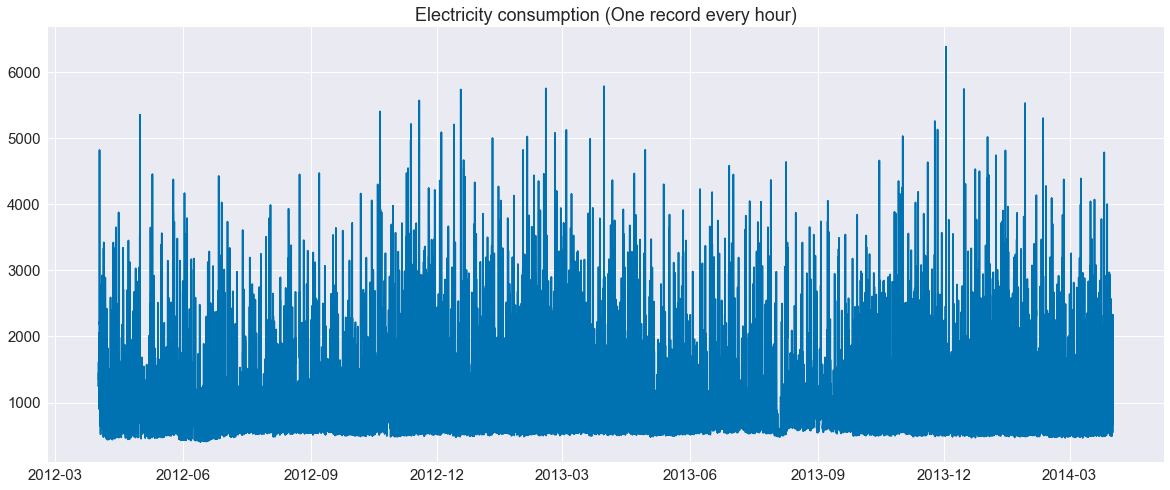

In [10]:
plot_series(df_hour, title='Electricity consumption (One record every hour)')

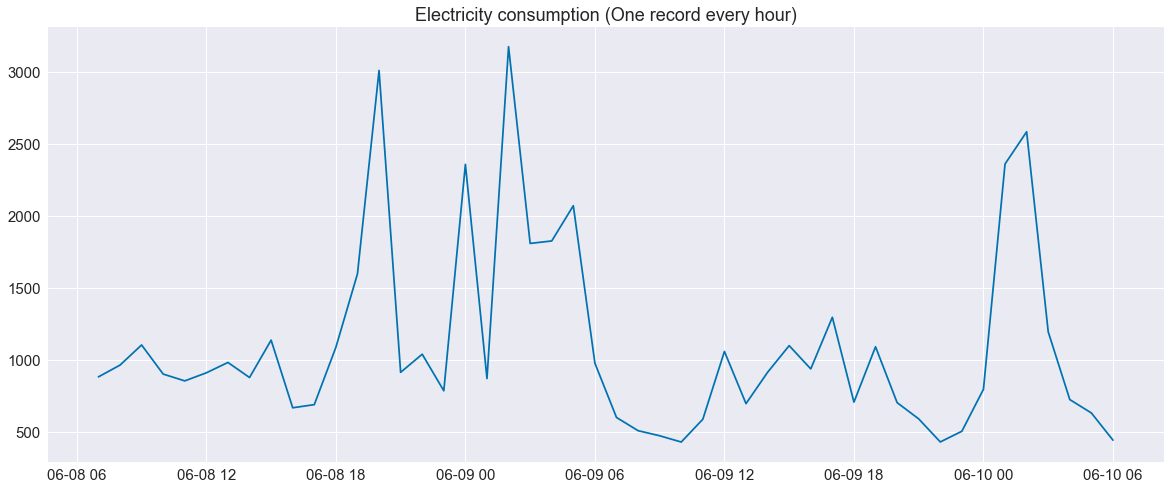

In [11]:
vancouver = pytz.timezone('America/Vancouver')
plot_series(
    df_hour[
        (df_hour.index.tz_convert(vancouver) >= pd.Timestamp(2012, 6, 8).tz_localize(vancouver)) &
        (df_hour.index.tz_convert(vancouver) < pd.Timestamp(2012, 6, 10).tz_localize(vancouver))
    ], 
    title='Electricity consumption (One record every hour)'
)

### Weather data

In [12]:
weather_df = pd.read_csv('./data/AMPds/Climate_HourlyWeather.csv', parse_dates=['Date/Time'])

In [13]:
weather_df.head()

,Date/Time,Year,Month,Day,Time,Data Quality,Temp (C),Temp Flag,Dew Point Temp (C),Dew Point Temp Flag,...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,2012-04-01 00:00:00,2012,4,1,00:00,NaN,4.3,NaN,2.3,NaN,...,NaN,12.9,NaN,99.88,NaN,NaN,NaN,NaN,NaN,Rain
1,2012-04-01 01:00:00,2012,4,1,01:00,NaN,4.4,NaN,2.2,NaN,...,NaN,8.0,NaN,99.94,NaN,NaN,NaN,NaN,NaN,Rain - Fog
2,2012-04-01 02:00:00,2012,4,1,02:00,NaN,3.8,NaN,1.6,NaN,...,NaN,6.4,NaN,100.00,NaN,NaN,NaN,NaN,NaN,Rain - Fog
3,2012-04-01 03:00:00,2012,4,1,03:00,NaN,2.8,NaN,0.7,NaN,...,NaN,8.0,NaN,100.10,NaN,NaN,NaN,NaN,NaN,Rain - Fog
4,2012-04-01 04:00:00,2012,4,1,04:00,NaN,2.4,NaN,0.4,NaN,...,NaN,9.7,NaN,100.23,NaN,NaN,NaN,NaN,NaN,Moderate Rain


In [14]:
def plot_temperature(df):
    f, ax = plt.subplots(1, figsize=(20, 8))
    
    ax.plot(df['Date/Time'], df['Temp (C)'])
    
    ax.set_title('Temperature (C)')

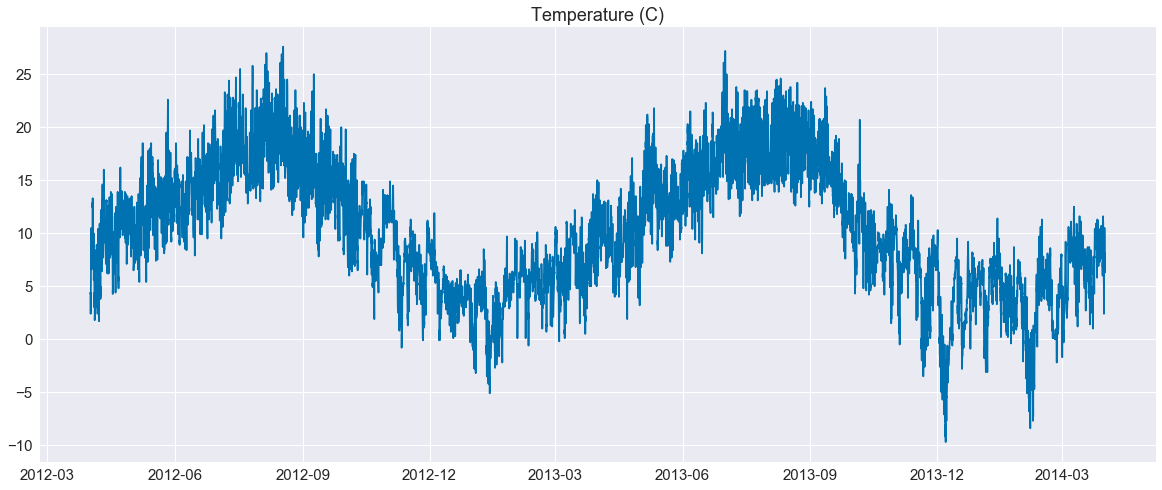

In [15]:
plot_temperature(weather_df)

What timezone?

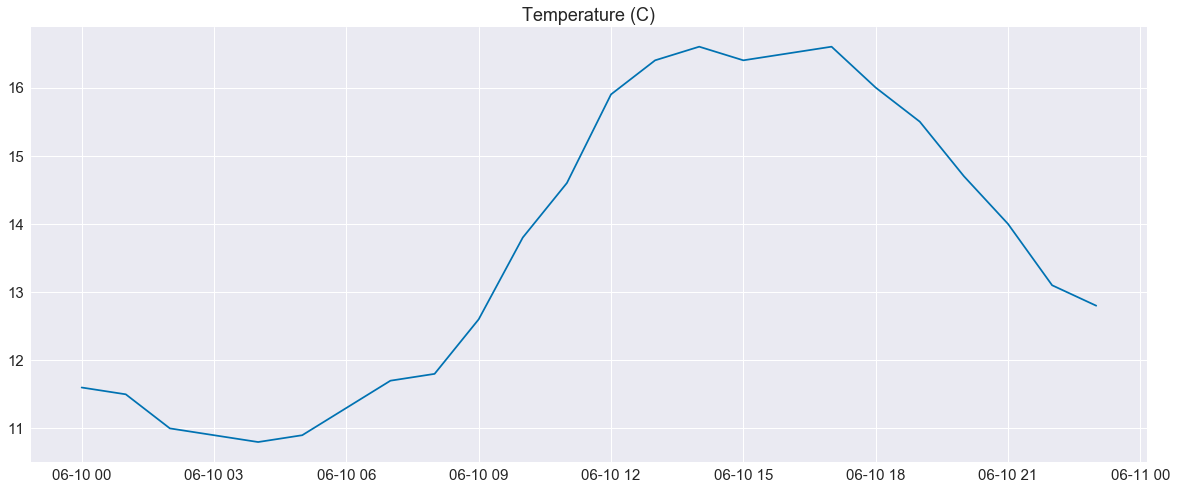

In [16]:
plot_temperature(
    weather_df[
        (weather_df['Date/Time'] >= pd.Timestamp(2012, 6, 10)) &
        (weather_df['Date/Time'] < pd.Timestamp(2012, 6, 11))
    ]
)

This plot suggests Vancouver time.

Convert to UTC:

In [17]:
weather_df['date_utc'] = weather_df['Date/Time'].apply(
    lambda v: pd.Timestamp(vancouver.localize(v.to_pydatetime()).astimezone(pytz.utc))
)
weather_df.set_index('date_utc', inplace=True)

In [18]:
weather_df

,Date/Time,Year,Month,Day,Time,Data Quality,Temp (C),Temp Flag,Dew Point Temp (C),Dew Point Temp Flag,...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
date_utc,,,,,,,,,,,,,,,,,,,,,
2012-04-01 07:00:00+00:00,2012-04-01 00:00:00,2012,4,1,00:00,NaN,4.3,NaN,2.3,NaN,...,NaN,12.9,NaN,99.88,NaN,NaN,NaN,NaN,NaN,Rain
2012-04-01 08:00:00+00:00,2012-04-01 01:00:00,2012,4,1,01:00,NaN,4.4,NaN,2.2,NaN,...,NaN,8.0,NaN,99.94,NaN,NaN,NaN,NaN,NaN,Rain - Fog
2012-04-01 09:00:00+00:00,2012-04-01 02:00:00,2012,4,1,02:00,NaN,3.8,NaN,1.6,NaN,...,NaN,6.4,NaN,100.00,NaN,NaN,NaN,NaN,NaN,Rain - Fog
2012-04-01 10:00:00+00:00,2012-04-01 03:00:00,2012,4,1,03:00,NaN,2.8,NaN,0.7,NaN,...,NaN,8.0,NaN,100.10,NaN,NaN,NaN,NaN,NaN,Rain - Fog
2012-04-01 11:00:00+00:00,2012-04-01 04:00:00,2012,4,1,04:00,NaN,2.4,NaN,0.4,NaN,...,NaN,9.7,NaN,100.23,NaN,NaN,NaN,NaN,NaN,Moderate Rain
2012-04-01 12:00:00+00:00,2012-04-01 05:00:00,2012,4,1,05:00,NaN,3.0,NaN,0.9,NaN,...,NaN,9.7,NaN,100.37,NaN,NaN,NaN,NaN,NaN,Rain
2012-04-01 13:00:00+00:00,2012-04-01 06:00:00,2012,4,1,06:00,NaN,3.7,NaN,1.7,NaN,...,NaN,12.9,NaN,100.55,NaN,NaN,NaN,NaN,NaN,Rain
2012-04-01 14:00:00+00:00,2012-04-01 07:00:00,2012,4,1,07:00,NaN,4.7,NaN,1.3,NaN,...,NaN,16.1,NaN,100.74,NaN,NaN,NaN,NaN,NaN,Mostly Cloudy
2012-04-01 15:00:00+00:00,2012-04-01 08:00:00,2012,4,1,08:00,NaN,5.3,NaN,1.3,NaN,...,NaN,24.1,NaN,100.94,NaN,NaN,NaN,NaN,NaN,Mostly Cloudy


Match with electricity dataset

In [19]:
weather_dedup_df = weather_df[~weather_df.index.duplicated(keep='first')]

In [20]:
weather_df.shape, weather_dedup_df.shape

((17520, 25), (17518, 25))

In [21]:
df_all = df_hour.merge(weather_dedup_df, left_index=True, right_index=True)

In [22]:
df_all.head()

,whe,Date/Time,Year,Month,Day,Time,Data Quality,Temp (C),Temp Flag,Dew Point Temp (C),...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
2012-04-01 07:00:00+00:00,1608.583333,2012-04-01 00:00:00,2012,4,1,00:00,NaN,4.3,NaN,2.3,...,NaN,12.9,NaN,99.88,NaN,NaN,NaN,NaN,NaN,Rain
2012-04-01 08:00:00+00:00,1245.483333,2012-04-01 01:00:00,2012,4,1,01:00,NaN,4.4,NaN,2.2,...,NaN,8.0,NaN,99.94,NaN,NaN,NaN,NaN,NaN,Rain - Fog
2012-04-01 09:00:00+00:00,1261.050000,2012-04-01 02:00:00,2012,4,1,02:00,NaN,3.8,NaN,1.6,...,NaN,6.4,NaN,100.00,NaN,NaN,NaN,NaN,NaN,Rain - Fog
2012-04-01 10:00:00+00:00,1266.333333,2012-04-01 03:00:00,2012,4,1,03:00,NaN,2.8,NaN,0.7,...,NaN,8.0,NaN,100.10,NaN,NaN,NaN,NaN,NaN,Rain - Fog
2012-04-01 11:00:00+00:00,1402.050000,2012-04-01 04:00:00,2012,4,1,04:00,NaN,2.4,NaN,0.4,...,NaN,9.7,NaN,100.23,NaN,NaN,NaN,NaN,NaN,Moderate Rain


In [23]:
df_all.shape

(17518, 26)

### Prophet

Forecasting tool identifying seasonality and trend in a single value time series.

We'll take a look at the underlying distribution of energy consumption over time.

In [24]:
prophet_df = df_all[['whe']].reset_index()
prophet_df['index'] = prophet_df['index'].dt.tz_localize(None)
prophet_df.columns = ['ds', 'y']

In [25]:
model = Prophet(yearly_seasonality=True)
model.fit(prophet_df)

/Users/srom/workspace/ds/env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [26]:
future = model.make_future_dataframe(periods=1)

In [27]:
forecast = model.predict(future)

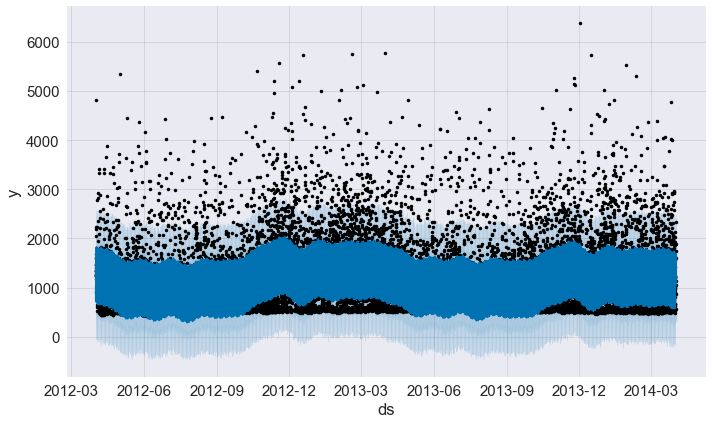

In [28]:
model.plot(forecast);

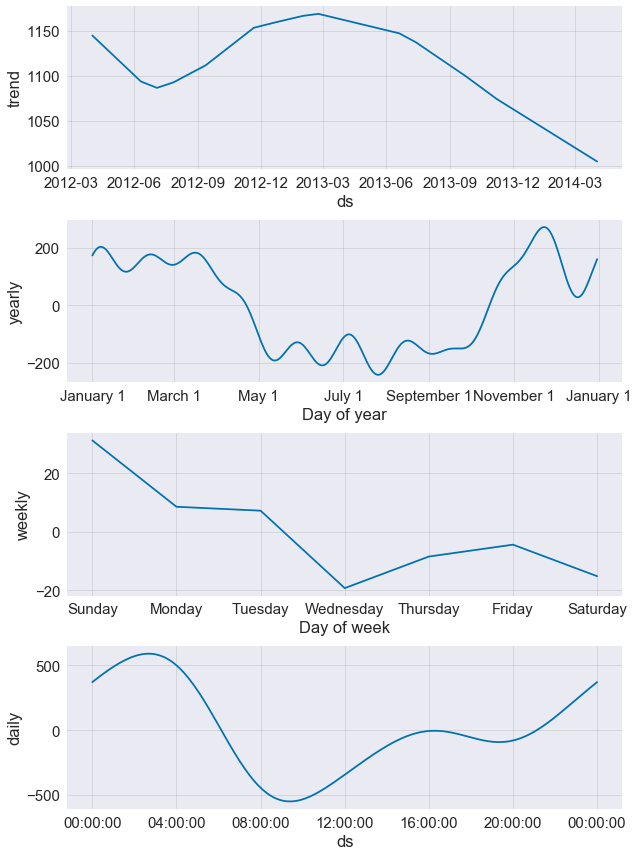

In [29]:
model.plot_components(forecast);

In [30]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
17514,2014-04-01 03:00:00,1695.249252,948.621200,2467.917872
17515,2014-04-01 04:00:00,1609.621601,866.490293,2368.429304
17516,2014-04-01 05:00:00,1415.373650,633.425183,2200.441264
17517,2014-04-01 06:00:00,1145.756550,405.253067,1871.099338
17518,2014-04-02 06:00:00,1109.279635,290.045024,1826.865735


### LSTM network

#### Consumption forecast

The game is to predict electricity consumption for a day on this house, knowing both the past consumption and the weather conditions. 

Past values are key to identify patterns of consumption independant of the weather (patterns proper to this house amenities and its occupants). 

Weather is the core exogenous factor driving consumption.

We'll use a long short-term memory network, a flavor of recurrent neural network solving some of the core issues experienced by vanilla RNNs.

#### Models 

We'll train two distinct model:

1. Weather forecast model: predict temperature, dew point temperature, visibility, atmospheric pressure
2. Consumption forecast: use weather data + past consumption to predict future consumption

All 4 dimensions will be predicted by the first model for the next time step. 

The second model outputs the consumption prediction for the next time step.

#### Weather model

In [31]:
n_steps = 24
n_inputs = 4
n_neurons = 100
n_layers = 4
n_outputs = 4

In [32]:
weather_dedup_df.columns

Index(['Date/Time', 'Year', 'Month', 'Day', 'Time', 'Data Quality', 'Temp (C)',
       'Temp Flag', 'Dew Point Temp (C)', 'Dew Point Temp Flag', 'Rel Hum (%)',
       'Rel Hum Flag', 'Wind Dir (10s deg)', 'Wind Dir Flag',
       'Wind Spd (km/h)', 'Wind Spd Flag', 'Visibility (km)',
       'Visibility Flag', 'Stn Press (kPa)', 'Stn Press Flag', 'Hmdx',
       'Hmdx Flag', 'Wind Chill', 'Wind Chill Flag', 'Weather'],
      dtype='object')

In [33]:
X_weather_all = weather_dedup_df[['Temp (C)', 'Dew Point Temp (C)', 'Visibility (km)', 'Stn Press (kPa)']].dropna()
X_weather_all.shape

(17469, 4)

In [34]:
def get_X(m):
    return m[:-1,:]

def get_y(m):
    return m[1:, :]

def next_batch(X_all, batch_size):
    X__, y__ = [], []
    for x in np.random.randint(len(X_all) - (n_steps + 1), size=batch_size):
        matrix = X_all.iloc[x:x+n_steps+1].values
        X__.append(get_X(matrix))
        y__.append(get_y(matrix))

    return np.array(X__), np.array(y__)

X_, y_ = next_batch(X_weather_all, 2)
X_.shape, y_.shape

((2, 24, 4), (2, 24, 4))

In [35]:
def get_training_test_sets(X_all):
    last_slice = int(len(X_all) * 0.2)
    return X_all.iloc[:-last_slice,:], X_all.iloc[-last_slice:,:]

In [36]:
X_train, X_test = get_training_test_sets(X_weather_all)

X_weather_all.shape, X_train.shape, X_test.shape

((17469, 4), (13976, 4), (3493, 4))

In [37]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons),
    output_size=n_outputs
)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

/Users/srom/workspace/ds/env/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/srom/workspace/ds/env/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


In [38]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(rnn_outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [39]:
n_iterations = 1000
batch_size = 50

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(X_train, batch_size)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
            
    X_new, y_new = next_batch(X_test, 1)
    y_pred = sess.run(rnn_outputs, feed_dict={X: X_new})

y_pred[0], y_new[0]

0 	MSE: 2896.756
100 	MSE: 1996.3627
200 	MSE: 1428.6659
300 	MSE: 1092.0142
400 	MSE: 847.50586
500 	MSE: 651.0081
600 	MSE: 516.0658
700 	MSE: 405.70468
800 	MSE: 302.64926
900 	MSE: 218.36198


(array([[ 8.810227 ,  5.6796145, 22.945196 , 61.405994 ],
        [11.290778 ,  7.266456 , 29.325771 , 78.49686  ],
        [11.661488 ,  7.5065675, 30.286348 , 81.07049  ],
        [11.712602 ,  7.539683 , 30.418821 , 81.42545  ],
        [11.719506 ,  7.544177 , 30.436737 , 81.47347  ],
        [11.720455 ,  7.5447855, 30.439182 , 81.48004  ],
        [11.720583 ,  7.544869 , 30.43951  , 81.48095  ],
        [11.720636 ,  7.5448837, 30.43963  , 81.48122  ],
        [11.720636 ,  7.5448833, 30.43963  , 81.48123  ],
        [11.72064  ,  7.544884 , 30.439642 , 81.48124  ],
        [11.720644 ,  7.5448856, 30.439648 , 81.481255 ],
        [11.720644 ,  7.544886 , 30.439648 , 81.481255 ],
        [11.720646 ,  7.5448847, 30.439648 , 81.481255 ],
        [11.720648 ,  7.544886 , 30.439651 , 81.48126  ],
        [11.720646 ,  7.5448856, 30.439648 , 81.481255 ],
        [11.720646 ,  7.544885 , 30.439648 , 81.48126  ],
        [11.720648 ,  7.544886 , 30.439651 , 81.48126  ],
        [11.72